<a href="https://colab.research.google.com/github/rafaelfioretti/gru_thesis/blob/main/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load all libraries & Random Initializers

In [1]:
import warnings
import ast
import sys
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.layers import GRU, Dense, Dropout
from keras.models import Sequential
from keras import Input
from keras import utils
from keras import initializers

In [2]:
# print version
print('Python: %s' % sys.version)
print('Keras: %s' % keras.__version__)
print('tensorflow: %s' % tf.__version__)
warnings.filterwarnings("ignore")

# Initialize Seeds for Reproducibility
seed = 12345
keras.utils.set_random_seed(seed)
initializer_glorot_uniform = initializers.GlorotUniform(seed=seed)
tf.config.experimental.enable_op_determinism()

Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Keras: 2.15.0
tensorflow: 2.15.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Dataset Load + Features Completeness


First Step is to install the Ta-lib library, that will be used to calculate technical indicators

In [ ]:
!curl -L http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz -O && tar xzvf ta-lib-0.4.0-src.tar.gz


In [ ]:
!cd ta-lib && ./configure --prefix=/usr && make && make install && cd - && pip install ta-lib


In [ ]:
#Load the dataset
df = pd.read_csv('/content/gdrive/MyDrive/Mestrado/DVK_Uppsats/Implementation/dataset_full.csv', header=0,parse_dates=["Date"],converters={'Price': float})

# Display the DataFrame
print(df.head())


In [ ]:
import talib

#Calculate SMA, EMA, RSI

df['SMA'] = talib.SMA(df['Close Price'])
df['EMA'] = talib.EMA(df['Close Price'])
df['RSI'] = talib.RSI(df['Close Price'])


In [ ]:
#Drop the values from May that were used to calculate the RSI
df_dropped = df.drop(df.index[:31],inplace=True)
print(df.head())


In [ ]:
print(df.head(60))


In [ ]:
df.to_csv('/content/gdrive/MyDrive/Mestrado/DVK_Uppsats/Implementation/dataset_completed.csv', index=False)


# Dataset Preparation

In this section we will prepare the dataset, applying scaling, shaping the input into a 3D array and splitting the data between Train & Test

In [4]:
#df = pd.read_csv('/content/gdrive/MyDrive/Mestrado/DVK_Uppsats/Implementation/dataset_completed.csv', header=0,parse_dates=["Date"],converters={'Price': float})
df = pd.read_csv('/content/gdrive/MyDrive/dataset_completed.csv', header=0,parse_dates=["Date"],converters={'Price': float})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1826 non-null   datetime64[ns]
 1   Open           1826 non-null   float64       
 2   High           1826 non-null   float64       
 3   Low            1826 non-null   float64       
 4   Volume         1826 non-null   int64         
 5   Google Trends  1826 non-null   float64       
 6   GVZ            1826 non-null   float64       
 7   OFR FSI        1826 non-null   float64       
 8   Close Price    1826 non-null   float64       
 9   SMA            1826 non-null   float64       
 10  EMA            1826 non-null   float64       
 11  RSI            1826 non-null   float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 171.3 KB


In [6]:
df.describe()

,Date,Open,High,Low,Volume,Google Trends,GVZ,OFR FSI,Close Price,SMA,EMA,RSI
count,1826,1826.000000,1826.000000,1826.000000,1.826000e+03,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000,1826.000000
mean,2019-11-30 12:00:00,18640.906363,19130.435088,18097.133164,2.343137e+10,7.309863,15.392985,-2.162311,18654.533214,18431.579065,18416.596933,52.618795
min,2017-06-01 00:00:00,1932.619995,2058.770020,1843.030029,5.278560e+08,0.450000,8.880000,-4.364000,1929.819946,1943.011645,1940.641106,9.920239
25%,2018-08-31 06:00:00,6631.572266,6768.785156,6528.540039,6.107588e+09,2.380000,11.460000,-3.475750,6637.024902,6665.115019,6766.310376,42.513872
50%,2019-11-30 12:00:00,9481.151367,9668.195312,9276.264648,1.997973e+10,4.080000,14.790000,-2.730500,9480.549317,9467.363688,9362.939970,51.642027
75%,2021-02-28 18:00:00,33789.308595,34790.409182,32267.986815,3.404375e+10,7.500000,17.990000,-1.623638,33740.259767,34674.724431,34163.893221,62.521690
max,2022-05-31 00:00:00,67549.734380,68789.625000,66382.062500,3.509679e+11,100.000000,48.980000,10.266000,67566.828130,62792.418881,61839.701401,94.302215
std,NaN,17640.379603,18095.216951,17110.975615,2.054021e+10,9.787737,5.062886,2.084358,17634.277719,17519.236712,17423.510183,14.302528


In [7]:
#check whether any column is empty
missing_values = (df == "?").sum(axis=0)
print(missing_values)

Date             0
Open             0
High             0
Low              0
Volume           0
Google Trends    0
GVZ              0
OFR FSI          0
Close Price      0
SMA              0
EMA              0
RSI              0
dtype: int64


In [8]:
#Creating the main train DataFrames.
y_train_df = df['Close Price']
x_train_df = df.drop(columns='Date')
dataset_dates = df['Date']

#Define the size of the training set = 80%
# Train - 01/06/2017,31/05/2021
# Test  - 01/06/2021,31/05/2022
train_size = int(x_train_df.shape[0] * 0.8)

# Simulations Implementation


## Implementation Generic Methods

Contains

*   Generic method to transfer the datasets Many-to-One
*   Generic method to prepare the dataset (drop columns, split, scale, transform)
*   Generic Model creation & fit




In [9]:
#Generic Method to Create the Keras vector Many to One
def generic_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array



Generic Method to convert dataset into Many-to-One



In [10]:
#Generic function to create the dataset:
# Include what exogenous variable should be removed and the # of Steps
scaler_x = StandardScaler()
scaler_y = StandardScaler()

def create_datasets(gtrends=True,gvz=True,ofr=True,label=True,num_steps=30):

  #Create the dataset
  x_df_simu = x_train_df.copy()
  y_df_simu = y_train_df.copy()

  #Drop columns that are not part of the simulation
  #Verify Google Trends
  if(not gtrends):
    x_df_simu.drop(columns='Google Trends',inplace=True)

  #Verify GVZ
  if(not gvz):
    x_df_simu.drop(columns='GVZ',inplace=True)

  #Verify OFR
  if(not ofr):
    x_df_simu.drop(columns='OFR FSI',inplace=True)

  #Verify Label
  if(not label):
    x_df_simu.drop(columns='Close Price',inplace=True)

  #1 - Split
  x_train_df_simu = x_df_simu[:train_size]
  x_test_df_simu = x_df_simu[train_size:]

  y_train_df_simu = y_df_simu[:train_size]
  y_test_df_simu = y_df_simu[train_size:]

  #2 - Scale
  x_train_sc = scaler_x.fit_transform(x_train_df_simu)
  x_test_sc = scaler_x.transform(x_test_df_simu)

  y_train_sc = scaler_y.fit_transform(y_train_df_simu.to_numpy().reshape(-1, 1))
  y_test_sc = scaler_y.transform(y_test_df_simu.to_numpy().reshape(-1, 1))

  #3 - Transform the Array
  x_train_trans, y_train_trans = generic_data_transform(x_train_sc, y_train_sc, num_steps)

  assert x_train_trans.shape[0] == y_train_trans.shape[0]

  x_test_trans, y_test_trans = generic_data_transform(x_test_sc, y_test_sc, num_steps)

  assert x_test_trans.shape[0] == y_test_trans.shape[0]

  #4 - Confirm Shape
  print('Dataset created', x_train_trans.shape, y_train_trans.shape, x_test_trans.shape, y_test_trans.shape)

  return (x_train_trans, y_train_trans, x_test_trans, y_test_trans)

Method to create a generic Model based on the configuration received and fit with the received data

In [11]:
#Create the Generic Model
def model_gen_fit(x_train_data, y_train_data, x_test_data,y_test_data, config):

  #Extract configuration
  a_batch_size, b_epochs, c_dropout_rate, d_neurons, e_dense_unit, f_layers = config

  #Create the model
  model = Sequential()
  if(f_layers==1):
    model.add(GRU(d_neurons, activation='tanh', input_shape=(x_train_data.shape[1], x_train_data.shape[2]), return_sequences=False,kernel_initializer=initializer_glorot_uniform,bias_initializer='Zeros'))
    model.add(Dropout(c_dropout_rate))
  else:
    model.add(GRU(d_neurons, activation='tanh', input_shape=(x_train_data.shape[1], x_train_data.shape[2]), return_sequences=True,kernel_initializer=initializer_glorot_uniform,bias_initializer='Zeros'))
    model.add(Dropout(c_dropout_rate))
    model.add(GRU(d_neurons, activation='tanh', return_sequences=False,kernel_initializer=initializer_glorot_uniform,bias_initializer='Zeros'))
    model.add(Dropout(c_dropout_rate))

  model.add(Dense(units=e_dense_unit,activation='relu',kernel_initializer=initializer_glorot_uniform,bias_initializer='Zeros'))
  model.add(Dense(units=1,kernel_initializer=initializer_glorot_uniform,bias_initializer='Zeros'))

  #Compile the Model
  model.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError', 'RootMeanSquaredError'], #MeanAbsoluteError-  List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance.
              loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
              run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
              steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
             )

  #Fit the Model
  history = model.fit(x_train_data, # input data
                    y_train_data, # target data
                    batch_size=a_batch_size, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
                    epochs=b_epochs, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
                    verbose=0, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
                    callbacks=None, # default=None, list of callbacks to apply during training. See tf.keras.callbacks
                    validation_split=0.2, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch.
                    #validation_data=(X_test, y_test), # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch.
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
                    sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
                    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
                    steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined.
                    validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
                    validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
                    validation_freq=10, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
                    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
                    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
                    use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False.
                   )

  #results = model.evaluate(x_test_data, y_test_data,verbose=0)

  return model

## Grid Search

Generic Method with the parameters that should be used for the Grid Search

In [12]:
#Create config File for Grid Search
def create_grid_search():

  # a_batch_size = [64]
  # b_epochs = [10]
  # c_dropout_rate = [0.15]
  # d_neurons = [240] # -> 80,160,240,320
  # e_dense_unit = [15] #-> 10, 15, 20
  # f_layers = [1]

  a_batch_size = [64, 48, 32]
  b_epochs = [10, 25, 50]
  c_dropout_rate = [0.15, 0.20, 0.25]
  d_neurons = [320,240,180,60] # -> 80,160,240,320
  e_dense_unit = [10,15,20,30] #-> 10, 15, 20
  f_layers = [2,1]

  configs = list()
  for a in a_batch_size:
    for b in b_epochs:
      for c in c_dropout_rate:
        for d in d_neurons:
          for e in e_dense_unit:
            for f in f_layers:
              cfg = [a,b,c,d,e,f]
              configs.append(cfg)

  print('Total configs: %d' % len(configs))

  return configs

Grid Search Execution

Note: the five scenarios are executed in row and saved into a CSV file. It consumes a lot of memory, you might need to execute one per time.

In [13]:
# #Create Grid Search
# config = create_grid_search()
# columns=['MSE', 'RMSE', 'Config']

# #Simulation 1
# print("\n\n")
# print("------ Simulation 1 Started ------")
# grid_results_sim1 = pd.DataFrame(columns=['MSE', 'RMSE', 'Config'])

# x_train_trans_sim1, y_train_trans_sim1, x_test_trans_sim1, y_test_trans_sim1= create_datasets(gtrends=False,gvz=False,ofr=False,label=True,num_steps=30)

# for cfg in config:
#   model_sim1 = model_gen_fit(x_train_trans_sim1, y_train_trans_sim1, x_test_trans_sim1, y_test_trans_sim1, cfg)
#   results = model_sim1.evaluate(x_test_trans_sim1, y_test_trans_sim1,verbose=0,batch_size=cfg[0])
#   grid_results_sim1 = pd.concat([grid_results_sim1, pd.DataFrame({'MSE': results[0], 'RMSE': results[2], 'Config': [cfg]})], ignore_index=True)
#   print(grid_results_sim1.tail(1))

# grid_results_sim1.to_csv('/content/gdrive/MyDrive/grid_simulation1.csv', index=False)
# print("------ Simulation 1 Completed ------")

# #Simulation 2
# print("\n\n")
# print("------ Simulation 2 Started ------")

# grid_results_sim2 = pd.DataFrame(columns=['MSE', 'RMSE', 'Config'])

# x_train_trans_sim2, y_train_trans_sim2, x_test_trans_sim2, y_test_trans_sim2 = create_datasets(gtrends=True,gvz=False,ofr=False,label=True,num_steps=30)

# for cfg in config:
#   model_sim2 = model_gen_fit(x_train_trans_sim2, y_train_trans_sim2, x_test_trans_sim2, y_test_trans_sim2, cfg)
#   results = model_sim2.evaluate(x_test_trans_sim2, y_test_trans_sim2,verbose=0,batch_size=cfg[0])
#   grid_results_sim2 = pd.concat([grid_results_sim2, pd.DataFrame({'MSE': results[0], 'RMSE': results[2], 'Config': [cfg]})], ignore_index=True)
#   print(grid_results_sim2.tail(1))

# grid_results_sim2.to_csv('/content/gdrive/MyDrive/grid_simulation2.csv', index=False)
# print("------ Simulation 2 Completed ------")

# #Simulation 3
# print("\n\n")
# print("------ Simulation 3 Started ------")

# grid_results_sim3 = pd.DataFrame(columns=['MSE', 'RMSE', 'Config'])

# x_train_trans_sim3, y_train_trans_sim3, x_test_trans_sim3, y_test_trans_sim3 = create_datasets(gtrends=False,gvz=True,ofr=False,label=True,num_steps=30)

# for cfg in config:
#   model_sim3 = model_gen_fit(x_train_trans_sim3, y_train_trans_sim3, x_test_trans_sim3, y_test_trans_sim3, cfg)
#   results = model_sim3.evaluate(x_test_trans_sim3, y_test_trans_sim3,verbose=0,batch_size=cfg[0])
#   grid_results_sim3 = pd.concat([grid_results_sim3, pd.DataFrame({'MSE': results[0], 'RMSE': results[2], 'Config': [cfg]})], ignore_index=True)
#   print(grid_results_sim3.tail(1))

# grid_results_sim3.to_csv('/content/gdrive/MyDrive/grid_simulation3.csv', index=False)
# print("------ Simulation 3 Completed ------")

# #Simulation 4
# print("\n\n")
# print("------ Simulation 4 Started ------")
# grid_results_sim4 = pd.DataFrame(columns=['MSE', 'RMSE', 'Config'])

# x_train_trans_sim4, y_train_trans_sim4, x_test_trans_sim4, y_test_trans_sim4 = create_datasets(gtrends=False,gvz=False,ofr=True,label=True,num_steps=30)

# for cfg in config:
#   model_sim4 = model_gen_fit(x_train_trans_sim4, y_train_trans_sim4, x_test_trans_sim4, y_test_trans_sim4, cfg)
#   results = model_sim4.evaluate(x_test_trans_sim4, y_test_trans_sim4,verbose=0,batch_size=cfg[0])
#   grid_results_sim4 = pd.concat([grid_results_sim4, pd.DataFrame({'MSE': results[0], 'RMSE': results[2], 'Config': [cfg]})], ignore_index=True)
#   print(grid_results_sim4.tail(1))

# grid_results_sim4.to_csv('/content/gdrive/MyDrive/grid_simulation4.csv', index=False)
# print("------ Simulation 4 Completed ------")


# #Simulation 5
# print("\n\n")
# print("------ Simulation 5 Started ------")
# grid_results_sim5 = pd.DataFrame(columns=['MSE', 'RMSE', 'Config'])

# x_train_trans_sim5, y_train_trans_sim5, x_test_trans_sim5, y_test_trans_sim5 = create_datasets(gtrends=True,gvz=True,ofr=True,label=True,num_steps=30)

# for cfg in config:
#   model_sim5 = model_gen_fit(x_train_trans_sim5, y_train_trans_sim5, x_test_trans_sim5, y_test_trans_sim5, cfg)
#   results = model_sim5.evaluate(x_test_trans_sim5, y_test_trans_sim5,verbose=0,batch_size=cfg[0])
#   grid_results_sim5 = pd.concat([grid_results_sim5, pd.DataFrame({'MSE': results[0], 'RMSE': results[2], 'Config': [cfg]})], ignore_index=True)
#   print(grid_results_sim5.tail(1))

# grid_results_sim5.to_csv('/content/gdrive/MyDrive/grid_simulation5.csv', index=False)

# print("------ Simulation 5 Completed ------")

## Prediction


In [14]:
#Load grid search files
df_grid_sim1 = pd.read_csv('/content/gdrive/MyDrive/grid_simulation1.csv', header=0,converters={'MSE': float})
df_grid_sim2 = pd.read_csv('/content/gdrive/MyDrive/grid_simulation2.csv', header=0,converters={'MSE': float})
df_grid_sim3 = pd.read_csv('/content/gdrive/MyDrive/grid_simulation3.csv', header=0,converters={'MSE': float})
df_grid_sim4 = pd.read_csv('/content/gdrive/MyDrive/grid_simulation4.csv', header=0,converters={'MSE': float})
df_grid_sim5 = pd.read_csv('/content/gdrive/MyDrive/grid_simulation5.csv', header=0,converters={'MSE': float})

#Select the configuration with the lowest MSE
best_param_sim1 = df_grid_sim1.loc[df_grid_sim1['MSE'].idxmin()]
config_sim1 = ast.literal_eval(best_param_sim1['Config'])
best_param_sim2 = df_grid_sim2.loc[df_grid_sim2['MSE'].idxmin()]
config_sim2 = ast.literal_eval(best_param_sim2['Config'])
best_param_sim3 = df_grid_sim3.loc[df_grid_sim3['MSE'].idxmin()]
config_sim3 = ast.literal_eval(best_param_sim3['Config'])
best_param_sim4 = df_grid_sim4.loc[df_grid_sim4['MSE'].idxmin()]
config_sim4 = ast.literal_eval(best_param_sim4['Config'])
best_param_sim5 = df_grid_sim5.loc[df_grid_sim5['MSE'].idxmin()]
config_sim5 = ast.literal_eval(best_param_sim5['Config'])

###Simulation 1

In [15]:
#Simulation 1

#Create Dataset
x_train_trans_sim1, y_train_trans_sim1, x_test_trans_sim1, y_test_trans_sim1= create_datasets(gtrends=False,gvz=False,ofr=False,label=True,num_steps=30)

#Create the model
model_sim1 = model_gen_fit(x_train_trans_sim1, y_train_trans_sim1, x_test_trans_sim1, y_test_trans_sim1, config_sim1)

#Predict
prediction_sim1 = model_sim1.predict(x_test_trans_sim1,batch_size=config_sim1[0])

#Calculate Metrics
#1 - Calculate MSE
sim1_mse = mean_squared_error(y_test_trans_sim1, prediction_sim1)
#2 - Calculate RMSE
sim1_rmse = np.sqrt(sim1_mse)

Dataset created (1430, 30, 8) (1430, 1) (336, 30, 8) (336, 1)
7/7 [==============================] - 0s 2ms/step


###Simulation 2


In [16]:
#Simulation 2

#Create Dataset
x_train_trans_sim2, y_train_trans_sim2, x_test_trans_sim2, y_test_trans_sim2= create_datasets(gtrends=True,gvz=False,ofr=False,label=True,num_steps=30)

#Create the model
model_sim2 = model_gen_fit(x_train_trans_sim2, y_train_trans_sim2, x_test_trans_sim2, y_test_trans_sim2, config_sim2)

#Predict
prediction_sim2 = model_sim2.predict(x_test_trans_sim2,batch_size=config_sim2[0])

#Calculate Metrics
#1 - Calculate MSE
sim2_mse = mean_squared_error(y_test_trans_sim2, prediction_sim2)
#2 - Calculate RMSE
sim2_rmse = np.sqrt(sim2_mse)

Dataset created (1430, 30, 9) (1430, 1) (336, 30, 9) (336, 1)
6/6 [==============================] - 0s 9ms/step


###Simulation 3

In [17]:
#Simulation 3

#Create Dataset
x_train_trans_sim3, y_train_trans_sim3, x_test_trans_sim3, y_test_trans_sim3= create_datasets(gtrends=False,gvz=True,ofr=False,label=True,num_steps=30)

#Create the model
model_sim3 = model_gen_fit(x_train_trans_sim3, y_train_trans_sim3, x_test_trans_sim3, y_test_trans_sim3, config_sim3)

#Predict
prediction_sim3 = model_sim3.predict(x_test_trans_sim3,batch_size=config_sim3[0])

#Calculate Metrics
#1 - Calculate MSE
sim3_mse = mean_squared_error(y_test_trans_sim3, prediction_sim3)
#2 - Calculate RMSE
sim3_rmse = np.sqrt(sim3_mse)

Dataset created (1430, 30, 9) (1430, 1) (336, 30, 9) (336, 1)
6/6 [==============================] - 0s 2ms/step


###Simulation 4

In [18]:
#Simulation 4

#Create Dataset
x_train_trans_sim4, y_train_trans_sim4, x_test_trans_sim4, y_test_trans_sim4 = create_datasets(gtrends=False,gvz=False,ofr=True,label=True,num_steps=30)

#Create the model
model_sim4 = model_gen_fit(x_train_trans_sim4, y_train_trans_sim4, x_test_trans_sim4, y_test_trans_sim4, config_sim4)

#Predict
prediction_sim4 = model_sim4.predict(x_test_trans_sim4,batch_size=config_sim4[0])

#Calculate Metrics
#1 - Calculate MSE
sim4_mse = mean_squared_error(y_test_trans_sim4, prediction_sim4)
#2 - Calculate RMSE
sim4_rmse = np.sqrt(sim4_mse)

Dataset created (1430, 30, 9) (1430, 1) (336, 30, 9) (336, 1)
6/6 [==============================] - 0s 2ms/step


###Simulation 5

In [19]:
#Simulation 5

#Create Dataset
x_train_trans_sim5, y_train_trans_sim5, x_test_trans_sim5, y_test_trans_sim5 = create_datasets(gtrends=True,gvz=True,ofr=True,label=True,num_steps=30)

#Create the model
model_sim5 = model_gen_fit(x_train_trans_sim5, y_train_trans_sim5, x_test_trans_sim5, y_test_trans_sim5, config_sim5)

#Predict
prediction_sim5 = model_sim5.predict(x_test_trans_sim5,batch_size=config_sim5[0])

#Calculate Metrics
#1 - Calculate MSE
sim5_mse = mean_squared_error(y_test_trans_sim5, prediction_sim5)
#2 - Calculate RMSE
sim5_rmse = np.sqrt(sim5_mse)

Dataset created (1430, 30, 11) (1430, 1) (336, 30, 11) (336, 1)
11/11 [==============================] - 0s 2ms/step


## Comparison & Results

In [20]:
print('----Results----')
print('Simulation 1 - MSE: ', sim1_mse, ' - RMSE: ', sim1_rmse)
print('Simulation 2 - MSE: ', sim2_mse, ' - RMSE: ', sim2_rmse)
print('Simulation 3 - MSE: ', sim3_mse, ' - RMSE: ', sim3_rmse)
print('Simulation 4 - MSE: ', sim4_mse, ' - RMSE: ', sim4_rmse)
print('Simulation 5 - MSE: ', sim5_mse, ' - RMSE: ', sim5_rmse)

----Results----
Simulation 1 - MSE:  0.06035377151400424  - RMSE:  0.24567004602516002
Simulation 2 - MSE:  0.3449893996102816  - RMSE:  0.5873579825032444
Simulation 3 - MSE:  0.11916992531252354  - RMSE:  0.3452099727883358
Simulation 4 - MSE:  0.047960822854851086  - RMSE:  0.2189995955586473
Simulation 5 - MSE:  0.17059664649062936  - RMSE:  0.41303346897149795


In [21]:
#Invert Scaler
y_test_inverse = scaler_y.inverse_transform(y_test_trans_sim1)
result_pred_scenario1_inv = scaler_y.inverse_transform(prediction_sim1)
result_pred_scenario2_inv = scaler_y.inverse_transform(prediction_sim2)
result_pred_scenario3_inv = scaler_y.inverse_transform(prediction_sim3)
result_pred_scenario4_inv = scaler_y.inverse_transform(prediction_sim4)
result_pred_scenario5_inv = scaler_y.inverse_transform(prediction_sim5)

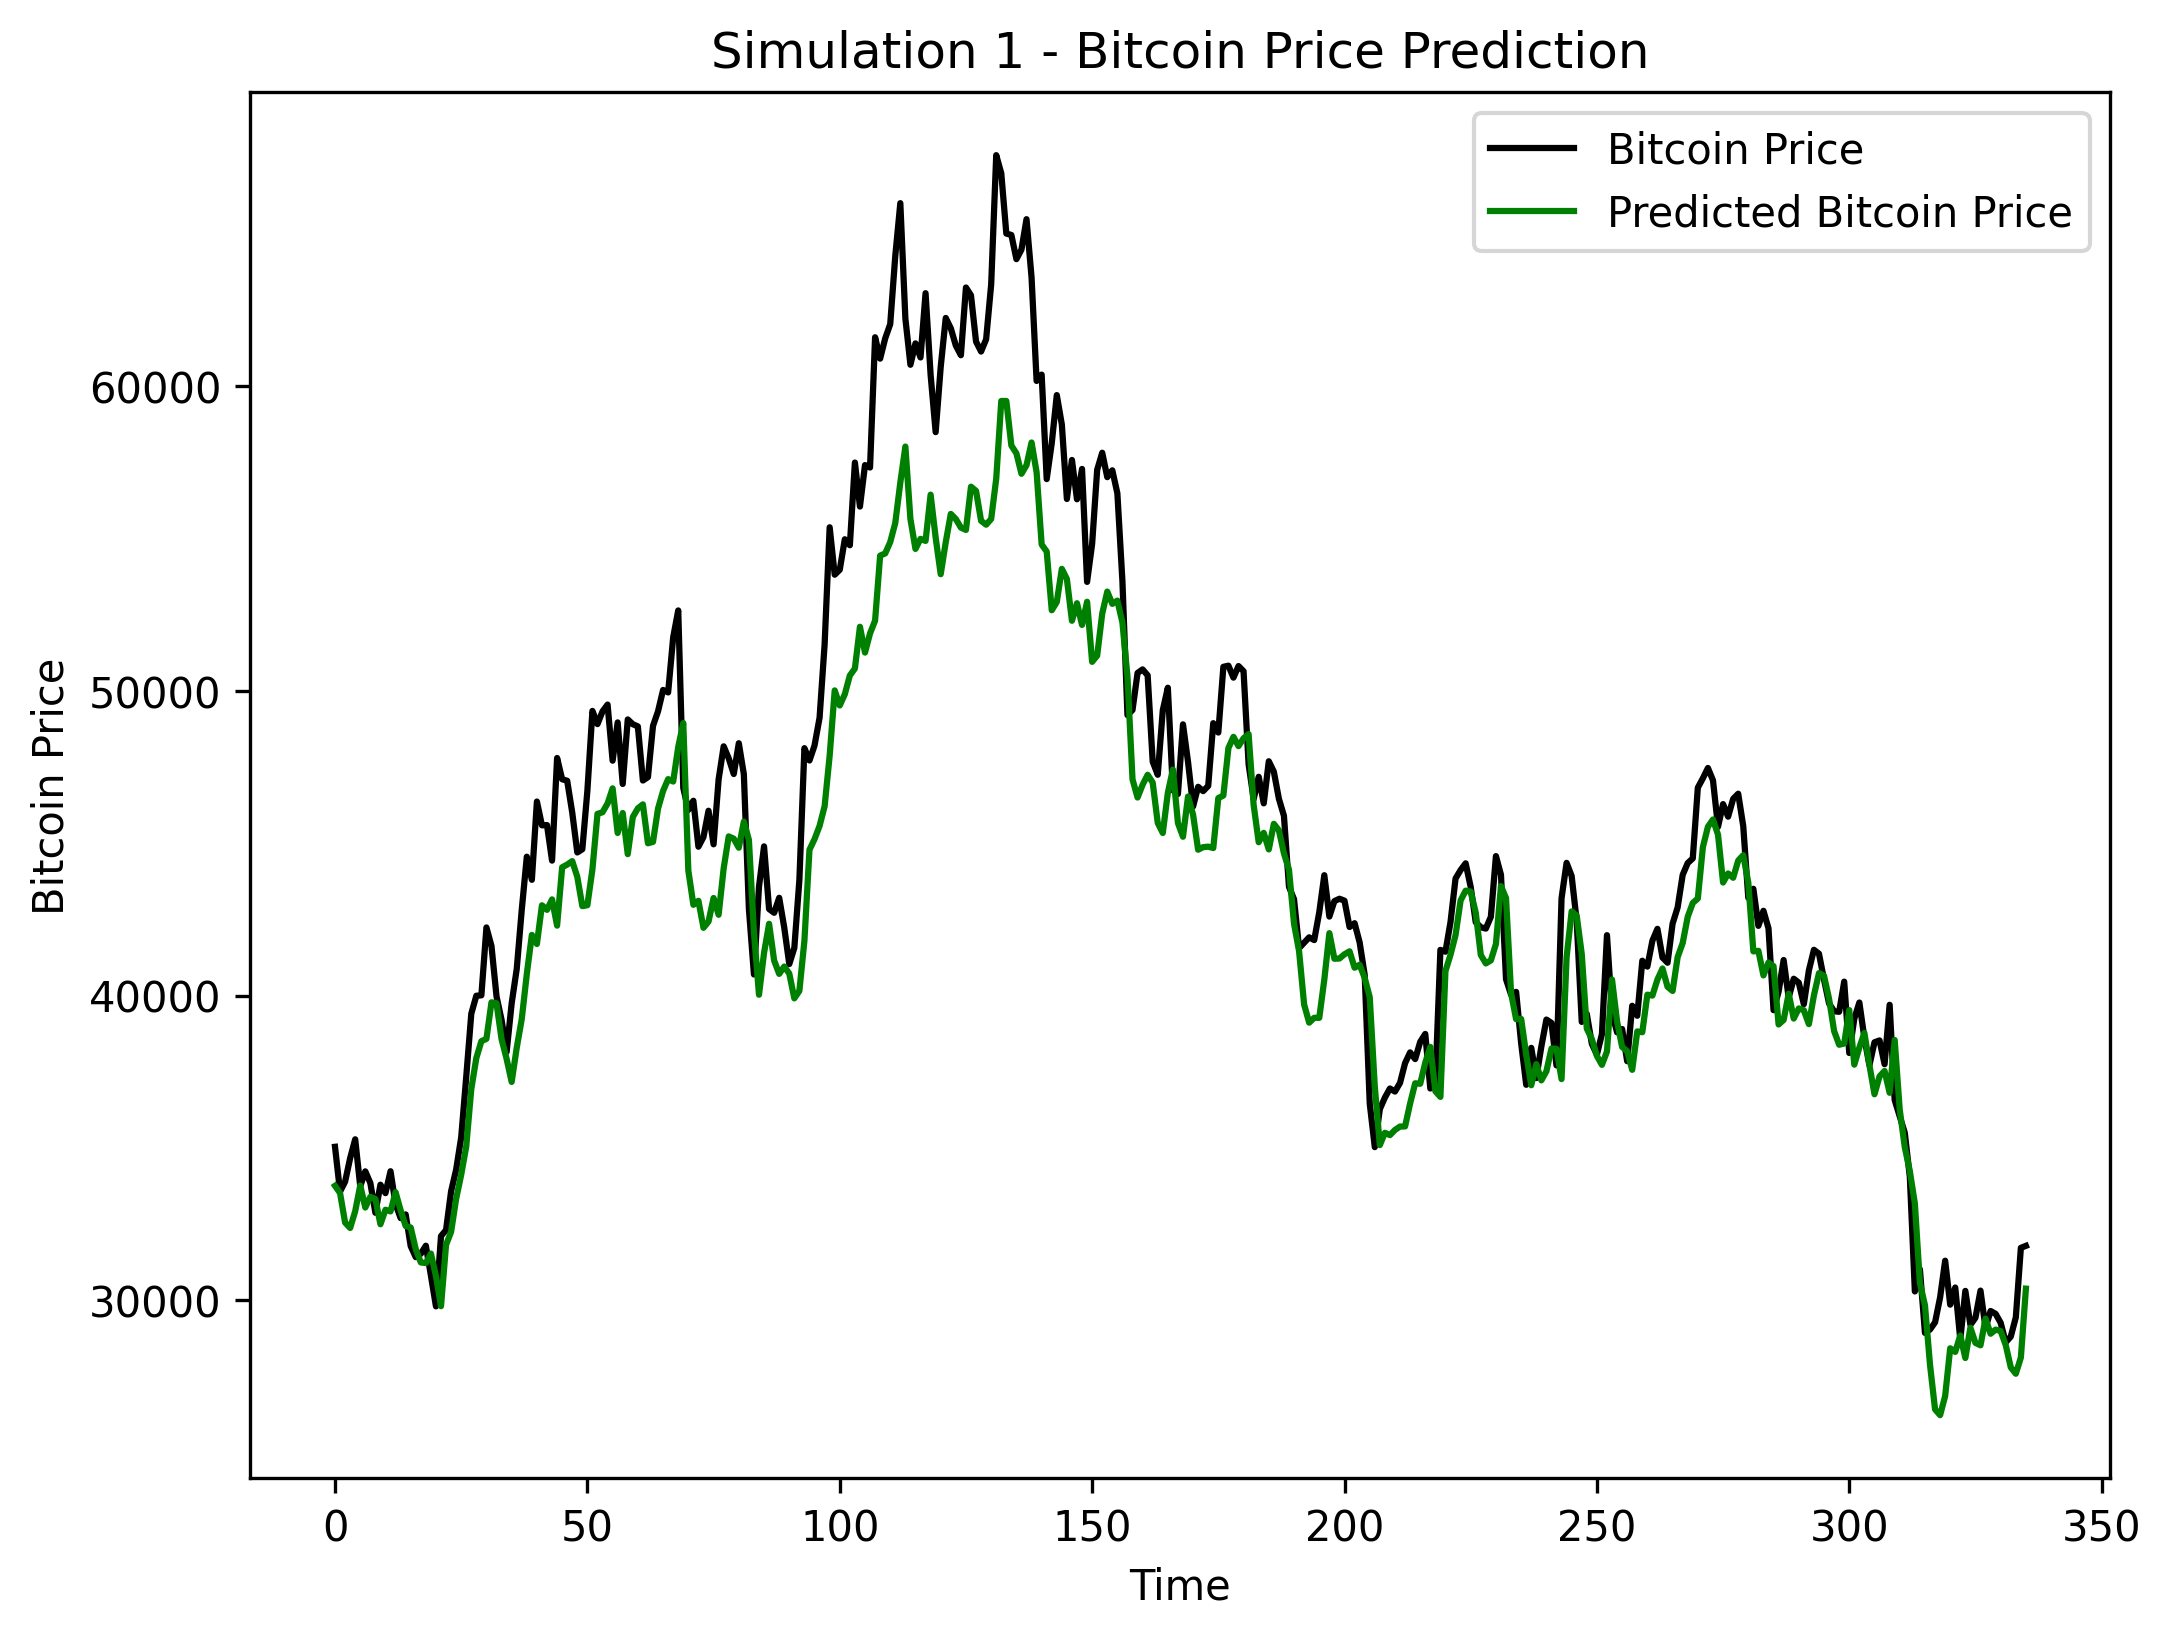

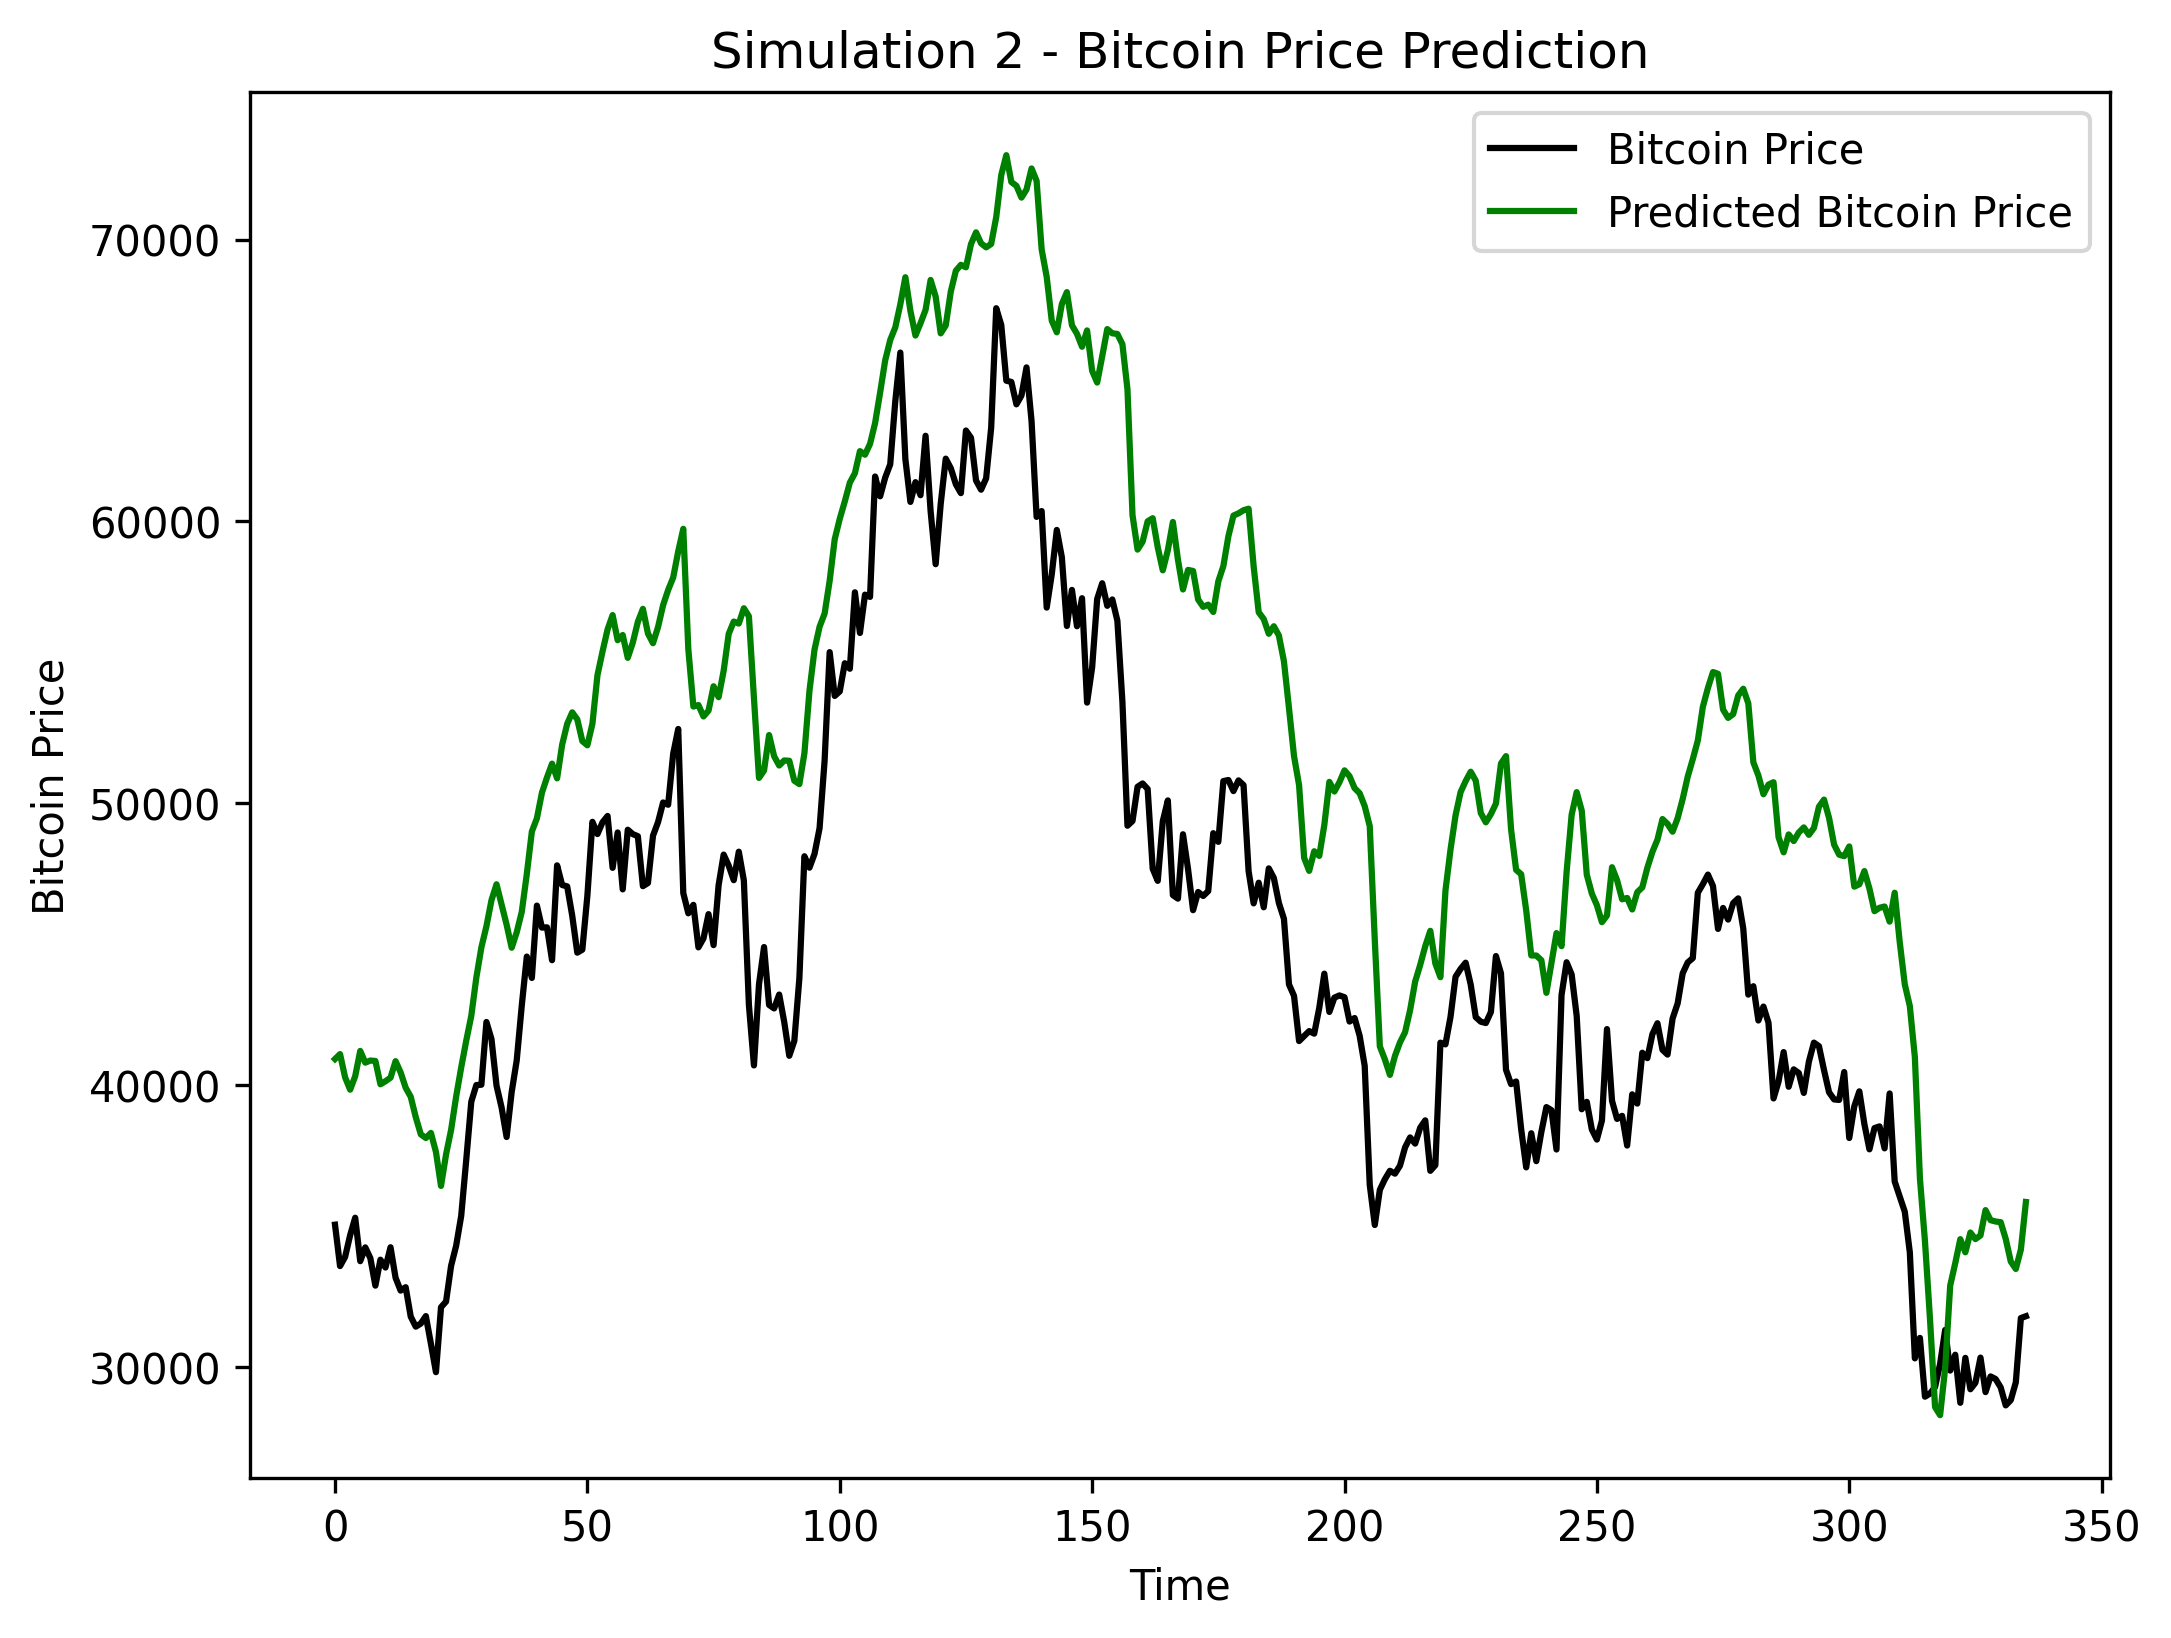

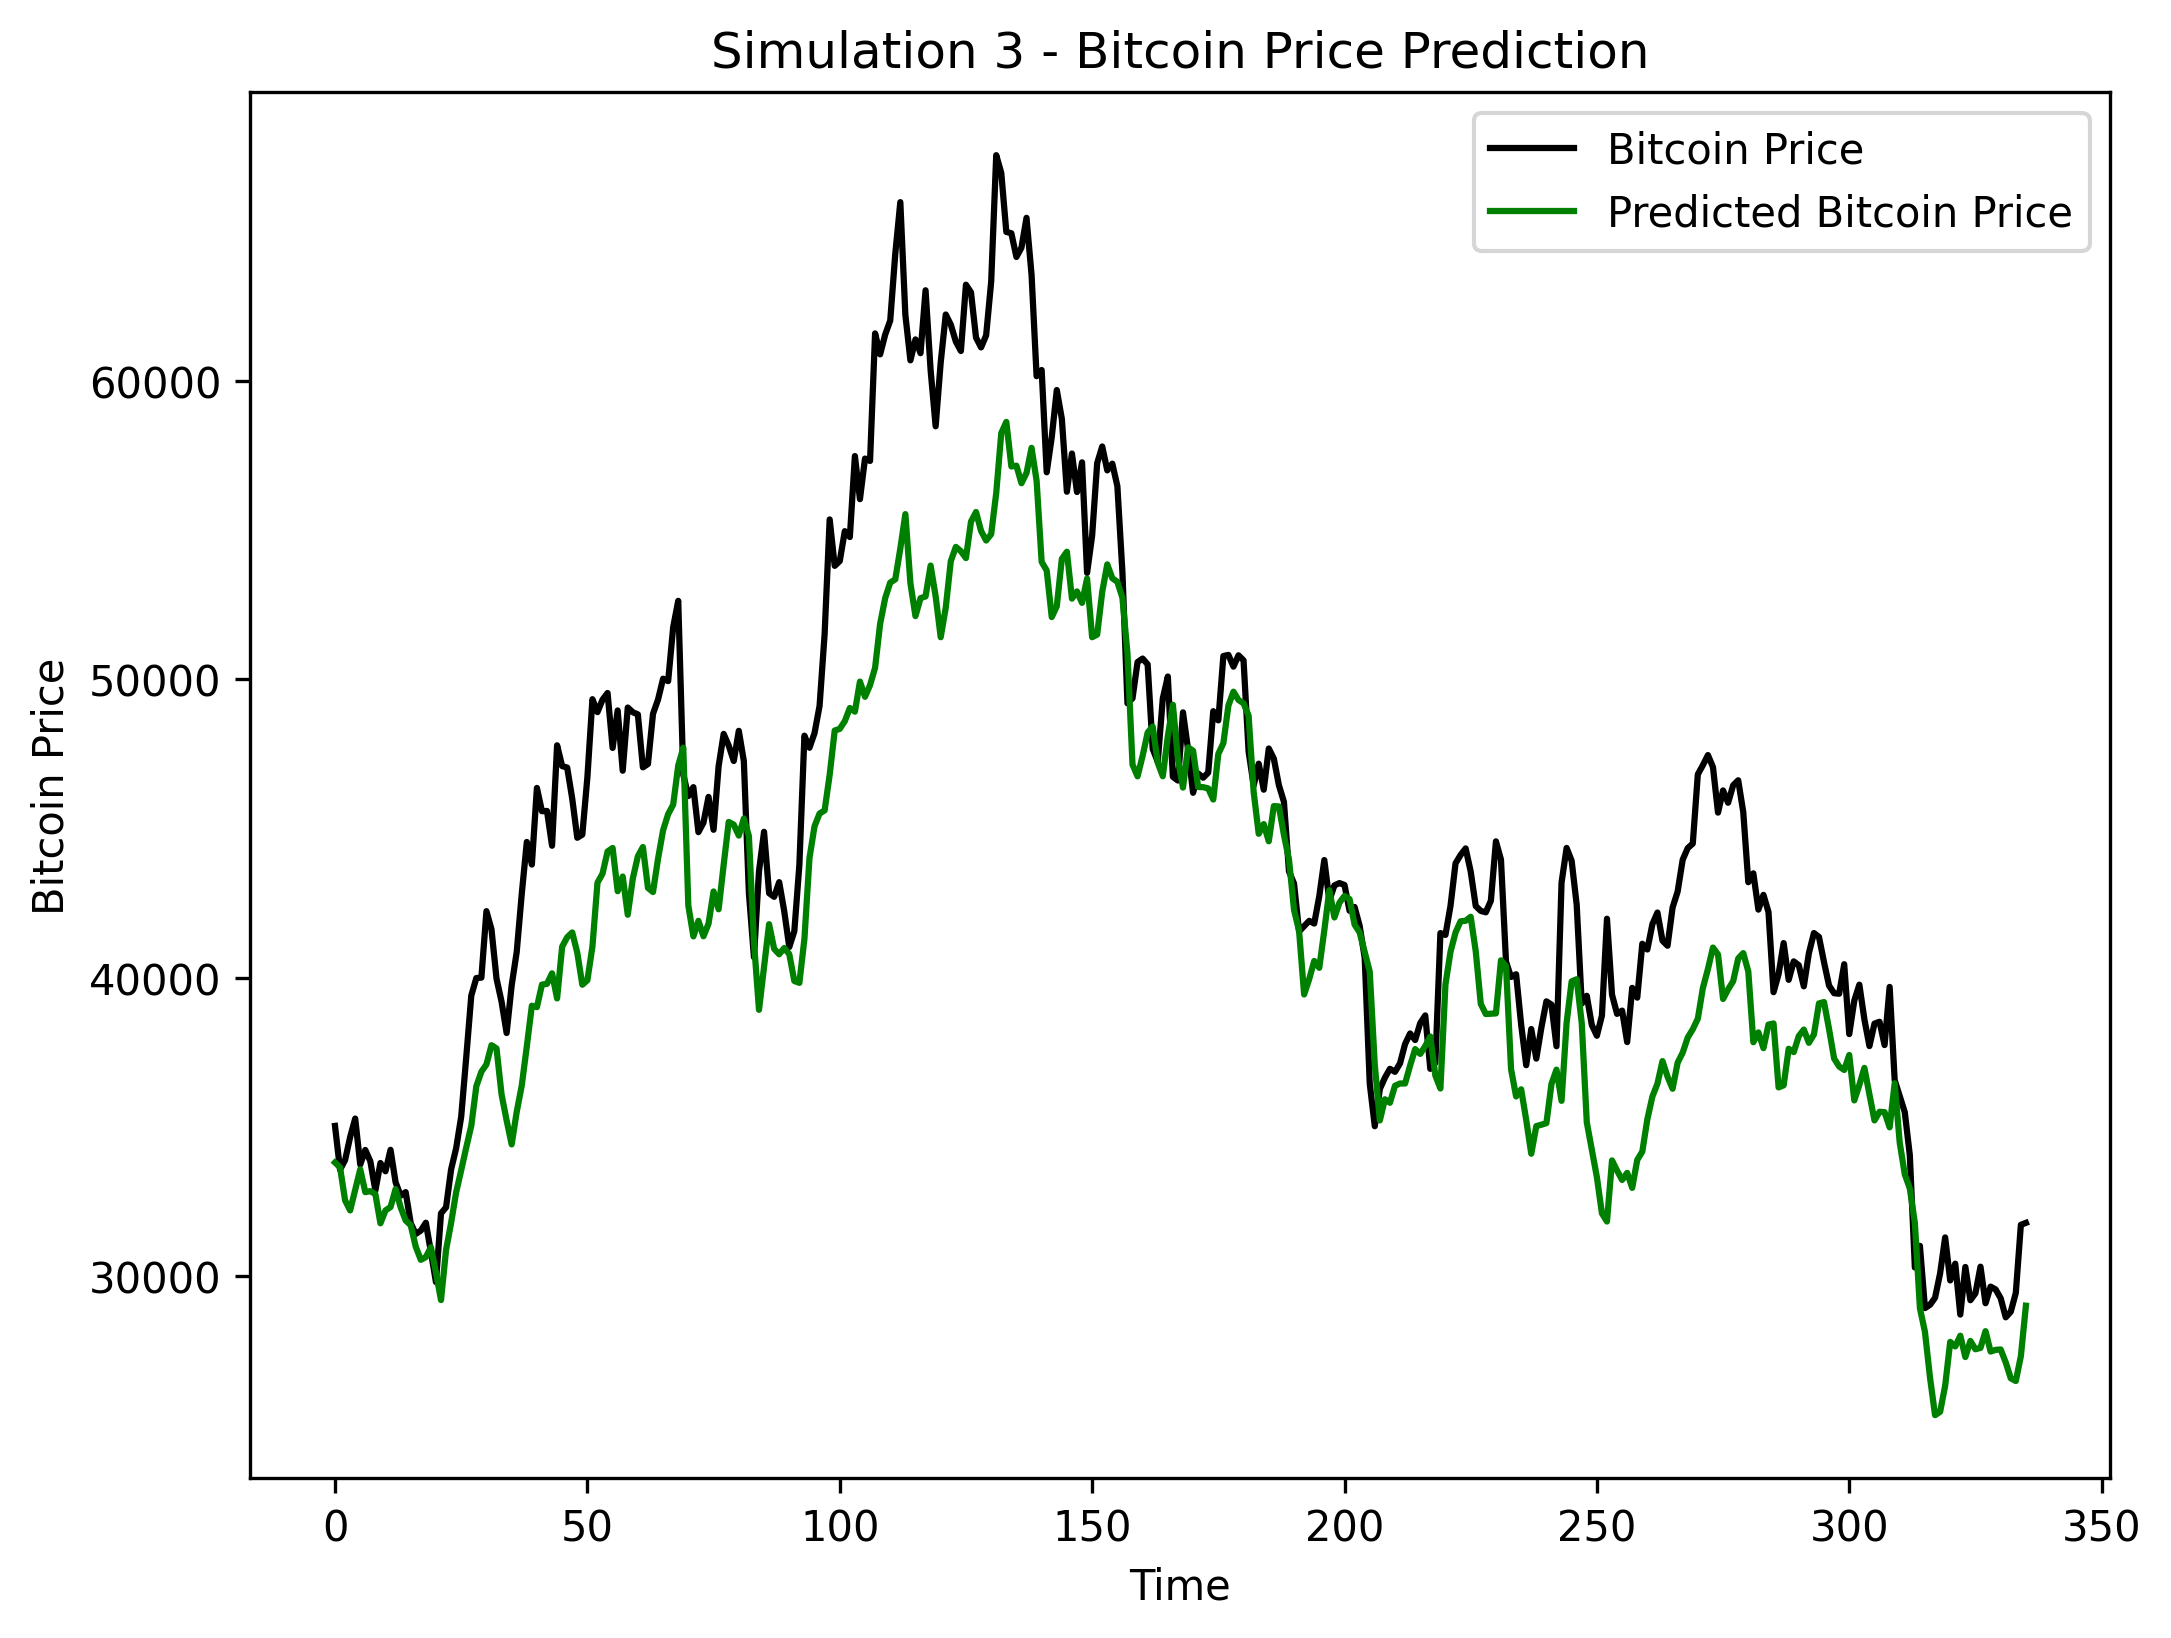

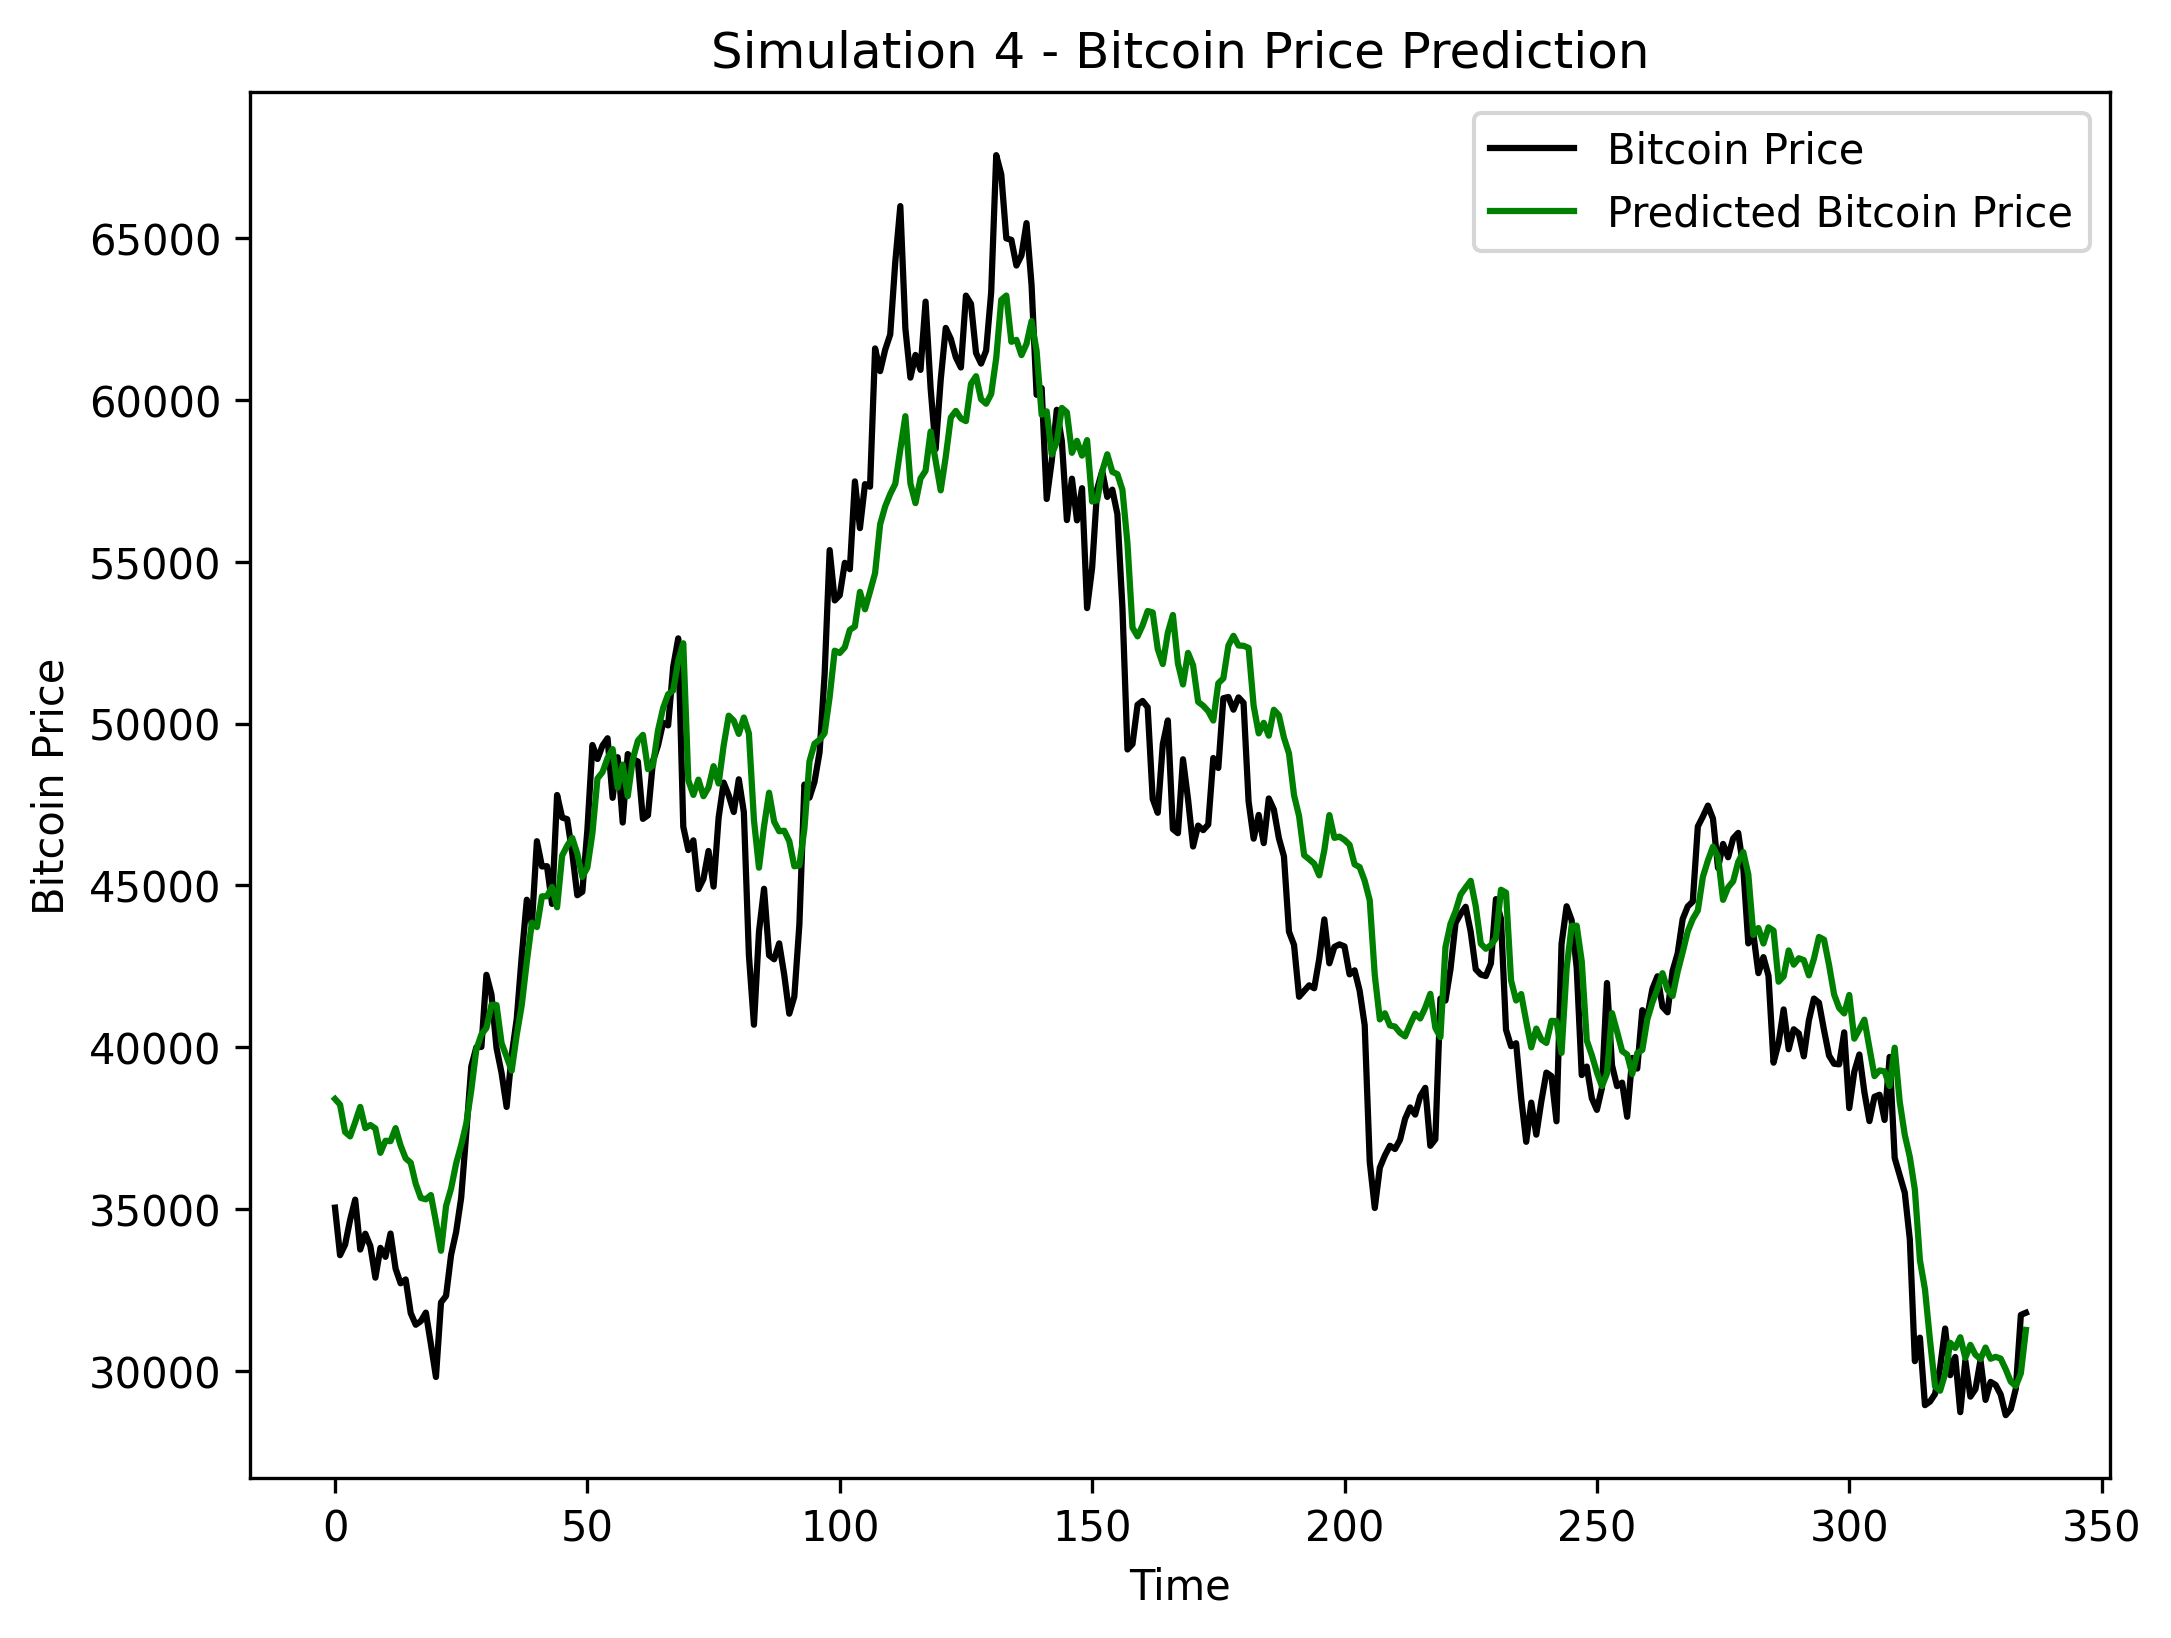

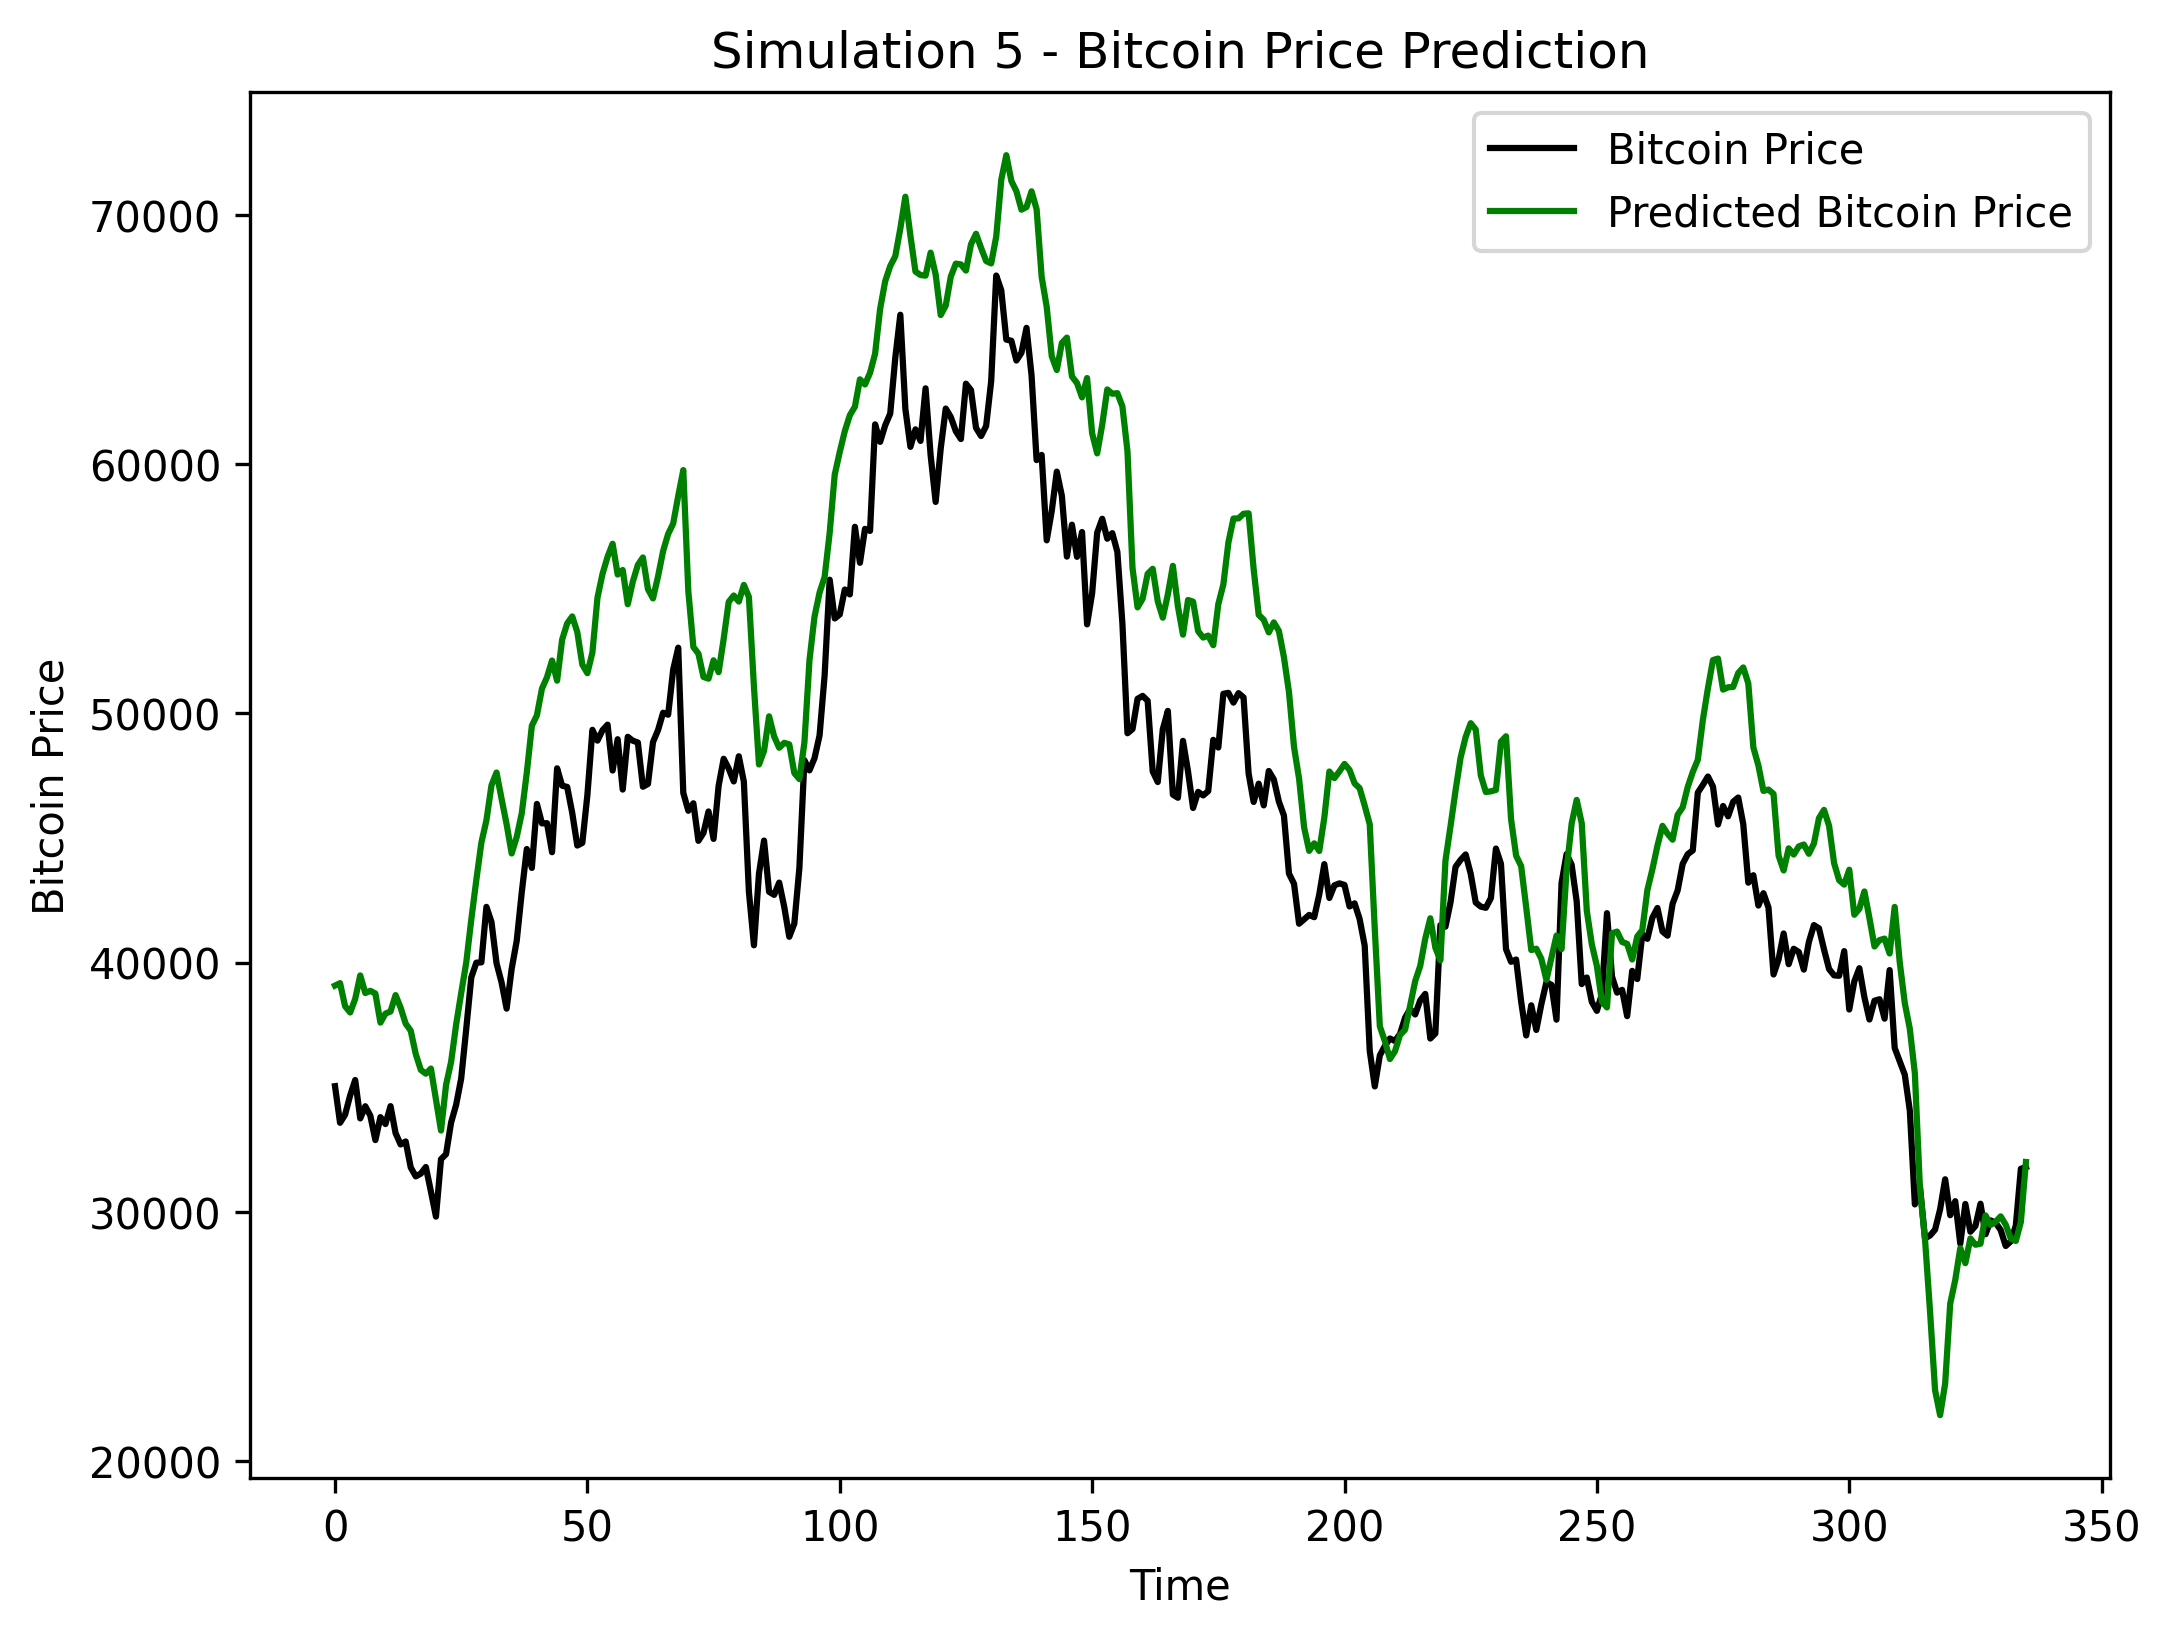

In [22]:
#Plot Graph 1
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(y_test_inverse, color = 'black', label = 'Bitcoin Price')
plt.plot(result_pred_scenario1_inv, color = 'green',label = 'Predicted Bitcoin Price')
plt.title('Simulation 1 - Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.savefig('Simulation1_graph.pdf')
plt.show()

#Plot Graph 2
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(y_test_inverse, color = 'black', label = 'Bitcoin Price')
plt.plot(result_pred_scenario2_inv, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Simulation 2 - Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.savefig('Simulation2_graph.pdf')
plt.show()


#Plot Graph 3
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(y_test_inverse, color = 'black', label = 'Bitcoin Price')
plt.plot(result_pred_scenario3_inv, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Simulation 3 - Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.savefig('Simulation3_graph.pdf')
plt.show()


#Plot Graph 4
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(y_test_inverse, color = 'black', label = 'Bitcoin Price')
plt.plot(result_pred_scenario4_inv, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Simulation 4 - Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.savefig('Simulation4_graph.pdf')
plt.show()


#Plot Graph 5
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(y_test_inverse, color = 'black', label = 'Bitcoin Price')
plt.plot(result_pred_scenario5_inv, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Simulation 5 - Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.savefig('Simulation5_graph.pdf')
plt.show()


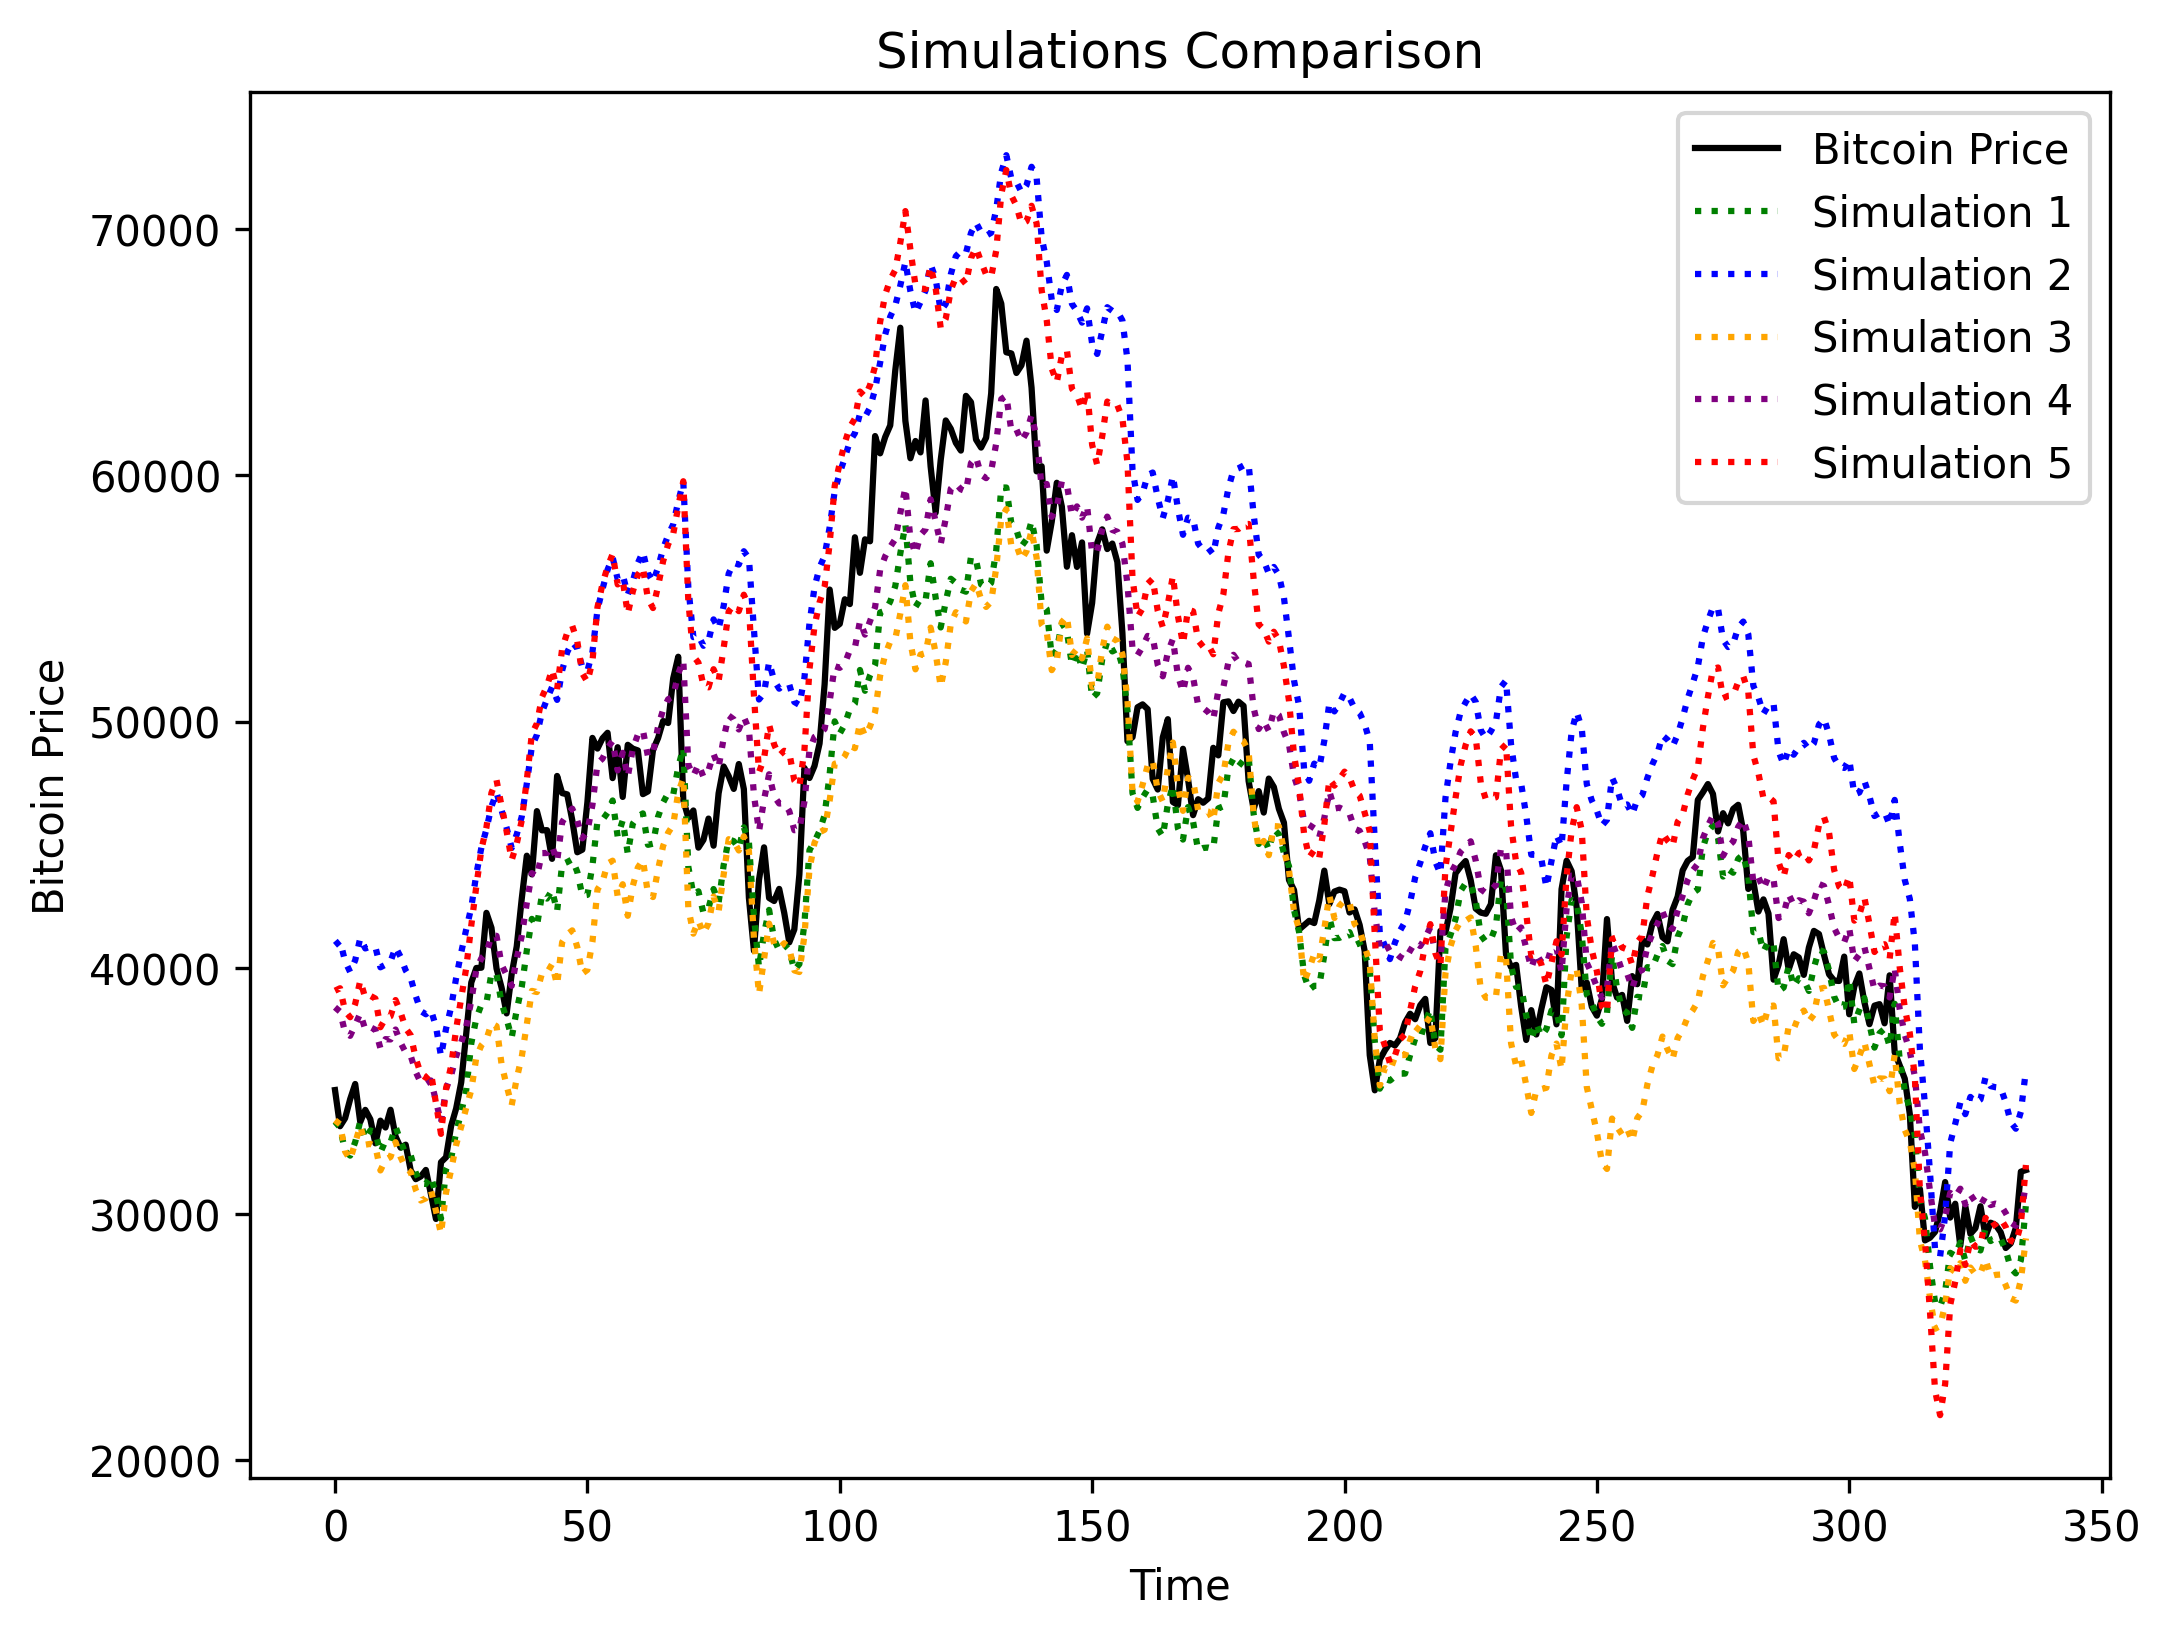

In [23]:
#Plot Graph Comparison
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(y_test_inverse, color = 'black', label = 'Bitcoin Price')
plt.plot(result_pred_scenario1_inv, linestyle=':',color = 'green', label = 'Simulation 1')
plt.plot(result_pred_scenario2_inv, linestyle=':',color = 'blue', label = 'Simulation 2')
plt.plot(result_pred_scenario3_inv, linestyle=':',color = 'orange', label = 'Simulation 3')
plt.plot(result_pred_scenario4_inv, linestyle=':',color = 'purple', label = 'Simulation 4')
plt.plot(result_pred_scenario5_inv, linestyle=':',color = 'red', label = 'Simulation 5')
plt.title('Simulations Comparison')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.savefig('Simulation_comparison.pdf')
plt.show()

In [24]:
# print("")
# print('-------------------- Model Summary --------------------')
# model.summary() # print model summary
# print("")
# #print('-------------------- Weights and Biases --------------------')
# #print("Too many parameters to print but you can use the code provided if needed")
# #print("")
# #for layer in model.layers:
# #    print(layer.name)
# #    for item in layer.get_weights():
# #        print("  ", item)
# #print("")

# # Print the last value in the evaluation metrics contained within history file
# print('-------------------- Evaluation on Training Data --------------------')
# for item in history.history:
#     print("Final", item, ":", history.history[item][-1])
# print("")

# # Evaluate the model on the test data using "evaluate"
# print('-------------------- Evaluation on Test Data --------------------')
# results = model.evaluate(x_test_simu1_trans, y_test_simu1_trans)
# print("")